In [319]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas_market_calendars as mcal
from datetime import datetime as dt
from datetime import timedelta 
import math

In [194]:
VALUATION_DATE = dt(year=2025, month=5, day=7)
DAY_CONVENTION = 'ACT/ACT' 


In [ ]:
target = mcal.get_calendar("EUREX")
target_days = target.schedule(start_date=VALUATION_DATE, end_date='2100-01-01')
target_days = target_days.index
target_days = list(target_days.to_pydatetime())

In [362]:
def tau(start_date: dt, end_date: dt, day_count_convention: str='ACT/ACT') -> float:

    # general check if end date greater or equal than start date
    if start_date > end_date:
        print("start date and end date are switched")

    year1 = int(start_date.year)
    year2 = int(end_date.year)

    # same year calculations 
    if year1==year2: 
        days_in_year = 366 if is_leap_year(year1) else 365
        return( (end_date - start_date).days / days_in_year )

    # multiple year calculations
    else: 
        # first fraction year 
        end_of_year1 = dt((year1 + 1), 1, 1)
        days_in_year1 = 366 if is_leap_year(year1) else 365
        frac1 = (end_of_year1 - start_date).days / days_in_year1
    
        # last fraction year
        start_of_year2 = dt(year2, 1, 1)
        days_in_year2 = 366 if is_leap_year(year2) else 365
        frac2 = (end_date - start_of_year2).days / days_in_year2

        # full years in between
        full_years = year2 - year1 - 1

        return( frac1 + full_years + frac2 )
    



def is_leap_year(year: int) -> bool:
    "function to determine if a year is a leap year"
    leap_year = year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
    return leap_year

In [ ]:
# unit tests for leap year
tests = {2025: False, 2000: True, 2048: True, 2019: False}

for year in tests.keys():
    print(f"For {year} test answer same as real answer: {(is_leap_year(year) == tests[year])}/n"  )


For 2025 test answer same as real answer: True

For 2000 test answer same as real answer: True

For 2048 test answer same as real answer: True

For 2019 test answer same as real answer: True



In [ ]:
# unit tests for tau function 
tests = {1: {'start_date': dt(2025, 5, 7), 
             'end_date': dt(2025, 5, 9),
             'day_count_convention': 'ACT/ACT',
             'answer': (2/365)},

        2: {'start_date': dt(2025, 5, 7), 
             'end_date': dt(2025, 7, 24),
             'day_count_convention': 'ACT/ACT',
             'answer': ( (24 + 30 + 31 - 7)/365 )},
        
        3: {'start_date': dt(2025, 5, 7), 
             'end_date': dt(2028, 5, 9),
             'day_count_convention': 'ACT/ACT', 
             'answer': ( 239/365 + 1 + 1 + 129/366 )},
              
        }

for i in tests.keys():

     function_answer = tau(start_date=tests[i]['start_date'],
                         end_date=tests[i]['end_date'],
                         day_count_convention=tests[i]['day_count_convention'])


     print( f"Answer is : {function_answer}" )
     print( f"Answer equals real answer: {function_answer==tests[i]['answer']}/n" )

Answer is : 0.005479452054794521
Answer equals real answer: True

Answer is : 0.2136986301369863
Answer equals real answer: True

Answer is : 3.0072535369413878
Answer equals real answer: True



In [ ]:
def next_business_day(figure_date: dt, business_days: list) -> dt:

    # if already a business day
    if figure_date in business_days:
        return figure_date

    # if not a business day
    else:
        for current_control_date in business_days:
            if current_control_date > figure_date:
                return current_control_date
            
        # if figure date after last day in business days list
        return None

In [160]:
# unit tests for next_business_day
tests = {'saturday': {'figure_date': dt(2025, 5, 31),
                      'answer': dt(2025, 6, 2)},
        
        'holiday': {'figure_date': dt(2026, 1, 1),
                    'answer': dt(2026, 1, 2)},

        'holiday_and_weekend_after': {'figure_date': dt(2025, 12, 25),
                                      'answer': dt(2025, 12, 29)},
        
        'working_day': {'figure_date': dt(2025, 5, 7),
                        'answer': dt(2025, 5, 7)}
    }

for test_name in tests.keys():
    function_answer = next_business_day(figure_date=tests[test_name]['figure_date'], business_days=target_days)
    print(f"The figure date is {tests[test_name]['figure_date'].date()}")
    print(f"The answer should be {tests[test_name]['answer'].date()}")
    print(f"Function returns the same: {tests[test_name]['answer']==function_answer}/n")

The figure date is 2025-05-31
The answer should be 2025-06-02
Function returns the same: True

The figure date is 2026-01-01
The answer should be 2026-01-02
Function returns the same: True

The figure date is 2025-12-25
The answer should be 2025-12-29
Function returns the same: True

The figure date is 2025-05-07
The answer should be 2025-05-07
Function returns the same: True



In [191]:
def plus_one_business_day(figure_date: dt, business_days: list) -> dt:

    # if figure date not a business day
    if figure_date not in business_days:
        current_date = next_business_day(figure_date=figure_date, business_days=business_days)
    else:
        current_date = figure_date

    figure_date_plus_one_day = current_date + timedelta(days=1)
    figure_date_plus_one_business_day = next_business_day(figure_date=figure_date_plus_one_day, business_days=business_days)

    return figure_date_plus_one_business_day

In [588]:
# unit tests for plus_one_business_day
tests = {'saturday': {'figure_date': dt(2025, 5, 31),
                      'answer': dt(2025, 6, 3)},
        
        'holiday': {'figure_date': dt(2026, 1, 1),
                    'answer': dt(2026, 1, 5)},

        'holiday_and_weekend_after': {'figure_date': dt(2025, 12, 25),
                                      'answer': dt(2025, 12, 30)},
        
        'working_day': {'figure_date': dt(2025, 5, 7),
                        'answer': dt(2025, 5, 8)}
    }

for test_name in tests.keys():
    function_answer = plus_one_business_day(figure_date=tests[test_name]['figure_date'], business_days=target_days)
    print(f"The figure date is {tests[test_name]['figure_date'].date()}")
    print(f"The answer should be {tests[test_name]['answer'].date()}")
    print(f"Function returns the same: {tests[test_name]['answer']==function_answer}\n")

The figure date is 2025-05-31
The answer should be 2025-06-03
Function returns the same: True

The figure date is 2026-01-01
The answer should be 2026-01-05
Function returns the same: True

The figure date is 2025-12-25
The answer should be 2025-12-30
Function returns the same: True

The figure date is 2025-05-07
The answer should be 2025-05-08
Function returns the same: True



In [161]:
def get_payment_dates(figure_date, maturity_date, business_days):
    payment_month = maturity_date.month 
    payment_day = maturity_date.day

    first_year = figure_date.year

    # next coupon date
    if (figure_date > dt(first_year, payment_month, payment_day)):
        first_year += 1
        next_coupon_date = dt((first_year), payment_month, payment_day)

    else:
        next_coupon_date = dt(first_year, payment_month, payment_day)

    first_payment_date = next_business_day(figure_date=next_coupon_date, business_days=business_days)
    payment_dates = []
    payment_dates.append(first_payment_date)

    n = maturity_date.year  - first_year
    current_year = first_year

    for _ in range(n):
        current_year += 1 
        current_coupon_date = dt(current_year, payment_month, payment_day)
        current_payment_date = next_business_day(figure_date=current_coupon_date, business_days=business_days)
        payment_dates.append(current_payment_date)

    return( payment_dates )


In [ ]:
payment_dates = get_payment_dates(figure_date=VALUATION_DATE, maturity_date=dt(2044, 1, 15), business_days=target_days)
payment_dates

[datetime.datetime(2026, 1, 15, 0, 0),
 datetime.datetime(2027, 1, 15, 0, 0),
 datetime.datetime(2028, 1, 17, 0, 0)]

In [272]:
def get_cashflows(payment_dates, maturity_date, coupon_rate, principal, business_days):
    
    coupon_payment = coupon_rate * principal
    cashflows = []

    for current_date in payment_dates:
        maturity_business_day = next_business_day(figure_date=current_date, business_days=business_days)
        if current_date==maturity_business_day:
            cashflows.append(coupon_payment + principal)
        else:
            cashflows.append(coupon_payment)

    return( cashflows )

In [ ]:
TOM = plus_one_business_day(figure_date=VALUATION_DATE, business_days=target_days)
SPOT = plus_one_business_day(figure_date=TOM, business_days=target_days)


2025-05-09 00:00:00


In [596]:
def get_cashflow_df(figure_date: dt, maturity_date: dt, business_days: list, day_count_convention: str):

    payment_dates = get_payment_dates(figure_date=figure_date, maturity_date=maturity_date, business_days=business_days)
    cashflows = get_cashflows(payment_dates=payment_dates, maturity_date=maturity_date, coupon_rate=0.0275, principal=100, business_days=business_days)
    cashflow_table = pd.DataFrame()
    cashflow_table['payment_date'] = payment_dates
    cashflow_table['cashflow'] = cashflows
    cashflow_table['time_to_figure_date'] = cashflow_table['payment_date'].apply(lambda x: tau(start_date=figure_date, end_date=x, day_count_convention=day_count_convention)) 
    cashflow_table['time_between_cashflows'] = cashflow_table['time_to_figure_date'] - cashflow_table['time_to_figure_date'].shift(1)
    cashflow_table.loc[0, 'time_between_cashflows'] = cashflow_table.loc[0, 'time_to_figure_date']

    return( cashflow_table )

In [599]:
cashflow_table = get_cashflow_df(figure_date=VALUATION_DATE, 
                                 maturity_date=dt(2044, 1, 15),
                                 business_days=target_days,
                                 day_count_convention=DAY_CONVENTION)
cashflow_table

,payment_date,cashflow,time_to_figure_date,time_between_cashflows
0,2026-01-15,102.75,0.693151,0.693151
1,2027-01-15,102.75,1.693151,1.000000
2,2028-01-17,102.75,2.698510,1.005360
3,2029-01-15,102.75,3.693151,0.994640
4,2030-01-15,102.75,4.693151,1.000000
5,2031-01-15,102.75,5.693151,1.000000
6,2032-01-15,102.75,6.693046,0.999895
7,2033-01-17,102.75,7.698630,1.005584
8,2034-01-16,102.75,8.695890,0.997260
9,2035-01-15,102.75,9.693151,0.997260


### TO IMPLEMENT

- ~~UNIT TESTS FOR PLUS_ONE_BUSINESS_DAY~~
- EXTRA UNIT TESTS FOR TIME FUNCTION, BECAUSE SEEMS IN CASHFLOW TABLE THAT WE CAN HAVE THAT 15 JAN TO 15 JAN NEXT YEAR IS NOT ALWAYS EQUAL TO 1
- YIELD ADJUSTED TO REAL DSL RATE AND DAY CONVENTION (STILL A SLIGHT DIFFERENCE, ALSO CHECK SPOT/VALUATION)
- INTERPOLATION TECHNIQUE 
- ADJUST LATEST FUNCTIONS TO CLASS

In [276]:
file_path = "C:/Users/joris/OneDrive/Documenten/GitHub/fixed-income/static_dsl_curve_snippet.xlsx"

dsl_df = pd.read_excel(file_path, index_col=0, header=0)
dsl_df['Maturity'] = pd.to_datetime(dsl_df['Maturity'])
dsl_df = dsl_df.sort_values(by='Maturity')

In [605]:
# DEPENDENCIES: 
"""
from datetime import datetime as dt
import pandas as pd
import pandas_market_calendars as mcal

"""
class Bond:
    def __init__(self, description: str, ticker: str, issue_date: dt, maturity_date: dt, 
                 price: float, coupon_rate: float, coupon_frequency: int = 1, 
                 day_count_convention: str = 'ACT/ACT', face_value: float = 100.0, currency: str = "EUR",
                 business_days: list = None):
        
        self._description = description
        self._ticker = ticker
        self._issue_date = issue_date
        self._maturity_date = maturity_date
        self._coupon_rate = coupon_rate
        self._coupon_frequency = coupon_frequency
        self._price = price
        self._day_count_convention = day_count_convention
        self._face_value = face_value
        self._currency = currency

        if business_days is None:
            target = mcal.get_calendar("EUREX")
            target_days = target.schedule(start_date=VALUATION_DATE, end_date='2100-01-01')
            target_days = target_days.index
            target_days = list(target_days.to_pydatetime())
            self._business_days = target_days
        else: 
            self._business_days = business_days

    # Getter methods
    def get_description(self) -> str:
        return self._description

    def get_ticker(self) -> str:
        return self._ticker

    def get_issue_date(self) -> dt:
        return self._issue_date

    def get_maturity_date(self) -> dt:
        return self._maturity_date

    def get_coupon_rate(self) -> float:
        return self._coupon_rate

    def get_coupon_frequency(self) -> int:
        return self._coupon_frequency

    def get_price(self) -> float:
        return self._price

    def get_day_count_convention(self) -> str:
        return self._day_count_convention

    def get_face_value(self) -> float:
        return self._face_value

    def get_currency(self) -> str:
        return self._currency

    def __str__(self):
        return f"{self._description} ({self._ticker}) - Matures on {self._maturity_date.date()}, Coupon: {self._coupon_rate*100:.2f}%"
    

    def get_summary(self) -> str:
        return (
            f"Bond Summary:\n"
            f"-----------------------------------------------------\n"
            f"Description:          {self.get_description()}\n"
            f"Ticker:               {self.get_ticker()}\n"
            f"Issue Date:           {self.get_issue_date()}\n"
            f"Maturity Date:        {self.get_maturity_date().date()}\n"
            f"Coupon Rate:          {self.get_coupon_rate()*100:.2f}%\n"
            f"Frequency:            {self.get_coupon_frequency()} times/year\n"
            f"Price:                {self.get_price()} {self.get_currency()}\n"
            f"Face Value:           {self.get_face_value()} {self.get_currency()}\n"
            f"Day Count:            {self.get_day_count_convention()}"
        )

    # Payment dates of bond
    def get_payment_dates(self, figure_date: dt) -> list:

        payment_month = self._maturity_date.month 
        payment_day = self._maturity_date.day
        first_year = figure_date.year

        # next coupon date
        if (figure_date > dt(first_year, payment_month, payment_day)):
            first_year += 1
            next_coupon_date = dt((first_year), payment_month, payment_day)

        else:
            next_coupon_date = dt(first_year, payment_month, payment_day)

        first_payment_date = next_business_day(figure_date=next_coupon_date, business_days=self._business_days)
        payment_dates = []
        payment_dates.append(first_payment_date)

        n = self._maturity_date.year  - first_year
        current_year = first_year

        for _ in range(n):
            current_year += 1 
            current_coupon_date = dt(current_year, payment_month, payment_day)
            current_payment_date = next_business_day(figure_date=current_coupon_date, business_days=self._business_days)
            payment_dates.append(current_payment_date)

        return( payment_dates )


    # Bond Cashflows
    def get_cashflows(self, figure_date: dt) -> list:
        
        payment_dates = self.get_payment_dates(figure_date=figure_date)
        coupon_payment = self._coupon_rate * self._face_value
        cashflows = []

        for current_date in payment_dates:
            maturity_business_day = next_business_day(figure_date=self._maturity_date, business_days=self._business_days)
            if current_date==maturity_business_day:
                cashflows.append(coupon_payment + self._face_value)
            else:
                cashflows.append(coupon_payment)

        return( cashflows )


    def get_cashflow_df(self, figure_date: dt) -> pd.DataFrame:

        payment_dates = self.get_payment_dates(figure_date=figure_date)
        cashflows = self.get_cashflows(figure_date=figure_date)
        cashflow_table = pd.DataFrame()
        cashflow_table['payment_date'] = payment_dates
        cashflow_table['cashflow'] = cashflows
        cashflow_table['time_to_figure_date'] = cashflow_table['payment_date'].apply(lambda x: tau(start_date=figure_date, end_date=x, day_count_convention=self._day_count_convention)) 
        cashflow_table['time_between_cashflows'] = cashflow_table['time_to_figure_date'] - cashflow_table['time_to_figure_date'].shift(1)
        cashflow_table.loc[0, 'time_between_cashflows'] = cashflow_table.loc[0, 'time_to_figure_date']
        
        return( cashflow_table )
    

    # Function to retrieve the bond yield implied by market price
    def get_yield(self, figure_date: dt) -> float:

        cashflow_table = self.get_cashflow_df(figure_date=figure_date)

        def func_to_solve(_yield):
            npv = 0

            for idx in cashflow_table.index:
                cashflow = cashflow_table.loc[idx, 'cashflow']
                time = cashflow_table.loc[idx, 'time_to_figure_date']

                npv +=  cashflow * ( 1 / (1 + _yield)**time )

            return( self._price - npv )
        
        res = fsolve(func=func_to_solve, x0=0.03)
        return res[0]



    def get_present_value(self, figure_date: dt) -> float:

        cashflow_table = self.get_cashflow_df(figure_date=figure_date)

        # TEMPORARY UNTIL GOOD METHOD FOR DISCOUNT FACTORS
        cashflow_table['discount_factor'] = 1 
        
        npv = 0
        for idx in cashflow_table.index:
            npv += cashflow_table.loc[idx, 'cashflow'] * cashflow_table.loc[idx, 'discount_factor']

        return npv




In [606]:
# Example for Bond Class
dsl0727 = Bond(description=dsl_df.loc[5, 'Bond'],
               ticker=dsl_df.loc[5, 'Ticker'],
               coupon_rate=dsl_df.loc[5, 'Coupon']/100,
               issue_date=dsl_df.loc[5, 'Issue Date'],
               maturity_date=dsl_df.loc[5, 'Maturity'],
               price=dsl_df.loc[5, 'Mid (price)'])

str(dsl0727)
print(dsl0727.get_summary())

Bond Summary:
-----------------------------------------------------
Description:          NETHER 0 3/4 07/15/27
Ticker:               AM206618 Corp
Issue Date:           9-2-2017
Maturity Date:        2027-07-15
Coupon Rate:          0.75%
Frequency:            1 times/year
Price:                97.7525 EUR
Face Value:           100.0 EUR
Day Count:            ACT/ACT


In [608]:
# Create our bond universe
bond_dict = {}

for bond_id in dsl_df.index:
    bond_dict[bond_id] = Bond(description=dsl_df.loc[bond_id, 'Bond'],
                              ticker=dsl_df.loc[bond_id, 'Ticker'],
                              coupon_rate=dsl_df.loc[bond_id, 'Coupon']/100,
                              issue_date=dsl_df.loc[bond_id, 'Issue Date'],
                              maturity_date=dsl_df.loc[bond_id, 'Maturity'],
                              price=dsl_df.loc[bond_id, 'Mid (price)'],
                              business_days=target_days)
    


In [609]:
print("Bootstrapping Procedure\n---------------------------------------------------")
for bond_id in bond_dict.keys():
    current_bond = bond_dict[bond_id]
    print(f"Currently stripping from: {current_bond.get_description()}")

    cashflow_table = current_bond.get_cashflow_df(figure_date=VALUATION_DATE)
    npv = current_bond.get_present_value(figure_date=VALUATION_DATE)
    y = current_bond.get_yield(figure_date=SPOT)
    print(f"NPV: {npv}")
    # print(f"Yield from opt: {y}")
    # print(f"Yield according to df: {dsl_df.loc[bond_id, 'Mid']/100}")


    

Bootstrapping Procedure
---------------------------------------------------
Currently stripping from: NETHER 0 1/4 07/15/25
NPV: 100.25
Currently stripping from: NETHER 0 01/15/26
NPV: 100.0
Currently stripping from: NETHER 0 1/2 07/15/26
NPV: 101.0
Currently stripping from: NETHER 0 01/15/27
NPV: 100.0
Currently stripping from: NETHER 0 3/4 07/15/27
NPV: 102.25
Currently stripping from: NETHER 5 1/2 01/15/28
NPV: 116.5
Currently stripping from: NETHER 0 3/4 07/15/28
NPV: 103.0
Currently stripping from: NETHER 0 01/15/29
NPV: 100.0
Currently stripping from: NETHER 0 1/4 07/15/29
NPV: 101.25
Currently stripping from: NETHER 2 1/2 01/15/30
NPV: 112.5
Currently stripping from: NETHER 0 07/15/30
NPV: 100.0
Currently stripping from: NETHER 0 07/15/31
NPV: 100.0
Currently stripping from: NETHER 0 1/2 07/15/32
NPV: 104.0
Currently stripping from: NETHER 2 1/2 01/15/33
NPV: 120.0
Currently stripping from: NETHER 2 1/2 07/15/33
NPV: 122.5
Currently stripping from: NETHER 2 1/2 07/15/34
NPV: 125

In [301]:
# get curve payment dates

figure_date = VALUATION_DATE
last_maturity_date = bond_dict[24].get_maturity_date()

first_payment_day = 15
first_payment_month = 1

second_payment_day = 15
second_payment_month = 7

current_year = figure_date.year

dates = []
dates.append(figure_date)

first_date = dt(current_year, first_payment_month, first_payment_day)
if first_date > figure_date:
    dates.append(first_date)

second_date = dt(current_year, second_payment_month, second_payment_day)
if second_date > figure_date:
    dates.append(second_date)

n_years = last_maturity_date.year - current_year

for _ in range(n_years):
    current_year += 1
    first_date = dt(current_year, first_payment_month, first_payment_day)
    second_date = dt(current_year, second_payment_month, second_payment_day)

    if first_date <= last_maturity_date:
        dates.append(first_date)
    
    if second_date <= last_maturity_date:
        dates.append(second_date)
    
    

all_payment_dates = [next_business_day(figure_date=d, business_days=target_days) for d in dates]

for d in all_payment_dates:
    print(f"{d.date()}")

2025-05-07
2025-07-15
2026-01-15
2026-07-15
2027-01-15
2027-07-15
2028-01-17
2028-07-17
2029-01-15
2029-07-16
2030-01-15
2030-07-15
2031-01-15
2031-07-15
2032-01-15
2032-07-15
2033-01-17
2033-07-15
2034-01-16
2034-07-17
2035-01-15
2035-07-16
2036-01-15
2036-07-15
2037-01-15
2037-07-15
2038-01-15
2038-07-15
2039-01-17
2039-07-15
2040-01-16
2040-07-16
2041-01-15
2041-07-15
2042-01-15
2042-07-15
2043-01-15
2043-07-15
2044-01-15
2044-07-15
2045-01-16
2045-07-17
2046-01-15
2046-07-16
2047-01-15
2047-07-15
2048-01-15
2048-07-15
2049-01-15
2049-07-15
2050-01-17
2050-07-15
2051-01-16
2051-07-17
2052-01-15
2052-07-15
2053-01-15
2053-07-15
2054-01-15


In [ ]:
def get_present_value(self, figure_date: dt) -> float:

    cashflow_table = self.get_cashflow_df(figure_date=figure_date)

    # TEMPORARY UNTIL GOOD METHOD FOR DISCOUNT FACTORS
    cashflow_table['discount_factor'] = 1 
    
    npv = 0
    for idx in cashflow_table.index:
        npv += cashflow_table.loc[idx, 'cashflow'] * cashflow_table.loc[idx, 'discount_factor']

    return npv

In [610]:
bond_id = 1
bond = bond_dict[bond_id]
bond_payment_dates = bond.get_payment_dates(figure_date=VALUATION_DATE)
bond_cashflow_df = bond.get_cashflow_df(figure_date=VALUATION_DATE)
price = bond_dict[bond_id].get_price()

discount_factors_df = pd.DataFrame(index=all_payment_dates)
discount_factors_df.loc[all_payment_dates[0], 'discount_factor'] = 1

payment_date = bond_cashflow_df.loc[0, 'payment_date']
d = discount_factors_df.loc[payment_date, 'discount_factor']
d
def func_to_solve(discount_factor):

    npv = 0

    for cashflow_idx in bond_cashflow_df.index:
        payment_date = bond_cashflow_df.loc[cashflow_idx, 'payment_date']
        cashflow = bond_cashflow_df.loc[cashflow_idx, 'cashflow']

        # two possibilities (either d is defined, or d is not yet defined)
        d = discount_factors_df.loc[payment_date, 'discount_factor']

        if math.isnan(d):
            # two possibilities (either d is the last discount factor for this bond, or we have to interpolate some dates)
            if ( len(bond_payment_dates) == (cashflow_idx + 1) ):
                d = discount_factor
            else: 
                # linear interpolation
                print('must still implement')

        npv += d * cashflow 
        
    return( npv - price )

df = fsolve(func=func_to_solve, x0=0.99)[0]
df

0.9942543640897755

In [612]:
- math.log(df) / 0.189041

0.030481247853937597

In [337]:
discount_factors_df = pd.DataFrame(index=all_payment_dates)
discount_factors_df.loc[all_payment_dates[0], 'discount_factor'] = 1

for bond_id in [1, 2, 3, 4, 5]:

    bond = bond_dict[bond_id]
    bond_payment_dates = bond.get_payment_dates(figure_date=VALUATION_DATE)
    bond_cashflow_df = bond.get_cashflow_df(figure_date=VALUATION_DATE)
    price = bond_dict[bond_id].get_price()

    def func_to_solve(discount_factor):

        npv = 0

        for cashflow_idx in bond_cashflow_df.index:
            payment_date = bond_cashflow_df.loc[cashflow_idx, 'payment_date']
            cashflow = bond_cashflow_df.loc[cashflow_idx, 'cashflow']

            # two possibilities (either d is defined, or d is not yet defined)
            d = discount_factors_df.loc[payment_date, 'discount_factor']

            if math.isnan(d):
                # two possibilities (either d is the last discount factor for this bond, or we have to interpolate some dates)
                if ( len(bond_payment_dates) == (cashflow_idx + 1) ):
                    d = discount_factor
                else: 
                    # linear interpolation
                    print('must still implement')
                    print(f"{len(bond_payment_dates)} is num payment dates, and {(cashflow_idx + 1)} is cashflow index")
                    print(bond.get_description())

            npv += d * cashflow 
            
        return( npv - price )

    df = fsolve(func=func_to_solve, x0=0.99)[0]

    # payment date is the last payment date
    discount_date = bond_payment_dates[-1]
    discount_factors_df.loc[discount_date, 'discount_factor'] = df

discount_factors_df

,discount_factor
2025-05-07,1.000000
2025-07-15,0.994254
2026-01-15,0.987495
2026-07-15,0.975267
2027-01-15,0.971025
2027-07-15,0.955587
2028-01-17,NaN
2028-07-17,NaN
2029-01-15,NaN
2029-07-16,NaN


In [ ]:
discount_factors = pd.DataFrame(index=all_payment_dates)

discount_factors.loc[all_payment_dates[0], 'discount_factor'] = 1

for date in all_payment_dates[1:]:
    d=date

In [338]:
bond_cashflow_df

,payment_date,cashflow,time_to_figure_date,time_between_cashflows
0,2025-07-15,0.75,0.189041,0.189041
1,2026-07-15,0.75,1.189041,1.000000
2,2027-07-15,100.75,2.189041,1.000000


In [579]:
def log_linear_interpolation(x, y1, x1, y2, x2):
    """ Log Linear Interpolation technique  """

    return( math.exp( math.log(y1) + ( (x - x1) / (x2 - x1) ) * (math.log(y2) - math.log(y1)) ) )

def linear_interpolation(x, y1, x1, y2, x2):
    return( y1 + (x - x1) / (x2 - x1) * (y2 - y1) )


In [570]:
def interpolate_strict(df, x_col, y_col):
    df = df.copy().reset_index(drop=True)

    # identify NaNs
    is_nan = df[y_col].isna()

    # label consecutive NaN groups 
    nan_group_labels = (is_nan != is_nan.shift()).cumsum()
    df['nan_group'] = nan_group_labels

    # only collect the groups of indices for consecutive NaN values
    nan_groups = is_nan[is_nan].groupby(nan_group_labels[is_nan])
    nan_index_groups = [group.index.tolist() for _, group in nan_groups]
    
    # Now for each consecutive group of NaN values we interpolate
    for idxs in nan_index_groups:
        idxs_np = np.array(idxs)
        # get index before and after the NaN group
        start_idx = idxs_np.min() - 1
        end_idx = idxs_np.max() + 1

        if start_idx < 0 or end_idx >= len(df):
            print("No interpolation possible")
            continue # skip if bounds are invalid (should not happen as we always impose a guessed value for the maturity date, and we work chronologically through the bonds)
        
        x1 = df.loc[start_idx, x_col]
        x2 = df.loc[end_idx, x_col]
        y1 = df.loc[start_idx, y_col]
        y2 = df.loc[end_idx, y_col]

        # interpolation
        for int_idx in idxs_np:
            x = df.loc[int_idx, x_col]    
            y = log_linear_interpolation(x=x, y1=y1, x1=x1, y2=y2, x2=x2)
            df.loc[int_idx, y_col] = y
            
    
    return df

    # print(df[nan_group[is_nan].unique()])
    # print(nan_group)
    # for group in df[nan_group[is_nan].unique()].groupby(nan_group):
        
    #     print(group)


In [584]:
y = log_linear_interpolation(12, 0.99, 5, 0.98, 13)
y_lin = linear_interpolation(12, 0.99, 5, 0.98, 13)
print(y)
print(y_lin)

0.9812444549729004
0.98125


In [572]:
def map_subset_to_main_df(main_df: pd.DataFrame, subset_df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    main_df[target_col] = main_df[target_col].where(~main_df.index.isin(subset_df.index), subset_df[target_col])
    return main_df


In [573]:
discount_factors_df = pd.DataFrame(index=all_payment_dates)
discount_factors_df.loc[all_payment_dates[0], 'discount_factor'] = 1



for bond_id in bond_dict.keys():

    bond = bond_dict[bond_id]
    bond_payment_dates = bond.get_payment_dates(figure_date=VALUATION_DATE)
    bond_cashflow_df = bond.get_cashflow_df(figure_date=VALUATION_DATE)
    price = bond.get_price()
    maturity_date = bond.get_maturity_date()
    maturity_business_day = next_business_day(figure_date=maturity_date, business_days=target_days)

    t = bond_cashflow_df[bond_cashflow_df['payment_date'] == maturity_business_day]['time_to_figure_date'].values[0]
    discount_factors_df.loc[maturity_business_day, 'discount_factor'] = math.exp(-0.02*t) #### This is the to be optimized value
    bond_cashflow_df['discount_factor'] = bond_cashflow_df.apply(lambda row: discount_factors_df.loc[row['payment_date'], 'discount_factor'], axis=1 )
    # bond_cashflow_df.loc[bond_cashflow_df['payment_date'] == maturity_business_day, 'discount_factor'] = 0.99 #### This is the to be optimized value

    # check if any NaNs
    check_nans = bond_cashflow_df['discount_factor'].isna().any()

    # If no NaNs, just move on to calculating the NPV
    if not check_nans:
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()
        print(f"For bond {bond.get_description()}, the NPV is: {npv:.2f}")
    else:
        print(f"For bond {bond.get_description()}, we must interpolate.")
        # print(bond_cashflow_df[['payment_date', 'time_to_figure_date', 'discount_factor']])
        df = interpolate_strict(df=bond_cashflow_df, x_col='time_to_figure_date', y_col='discount_factor')
        interpolated_discount_factors_df = pd.DataFrame(index=bond_payment_dates)
        interpolated_discount_factors_df['discount_factor'] = df['discount_factor'].values
    
        # replace the NaN discount factors for the interpolated 
        discount_factors_df = map_subset_to_main_df(main_df=discount_factors_df, subset_df=interpolated_discount_factors_df, target_col='discount_factor')

        # calculate NPV based on interpolated values
        bond_cashflow_df['discount_factor'] = bond_cashflow_df.apply(lambda row: discount_factors_df.loc[row['payment_date'], 'discount_factor'], axis=1 )
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()
        print(f"After interpolation, the NPV is: {npv:.2f}")
        

    print("---------------------------------------------------------------\n")

discount_factors_df['Date'] = all_payment_dates
discount_factors_df['Time'] = discount_factors_df.apply(lambda row: tau(start_date=VALUATION_DATE, end_date=row['Date'], day_count_convention='ACT/ACT'), axis=1) 
discount_factors_df = interpolate_strict(df=discount_factors_df, x_col='Time', y_col='discount_factor')


For bond NETHER 0 1/4 07/15/25, the NPV is: 99.87
---------------------------------------------------------------

For bond NETHER 0 01/15/26, the NPV is: 98.62
---------------------------------------------------------------

For bond NETHER 0 1/2 07/15/26, the NPV is: 98.64
---------------------------------------------------------------

For bond NETHER 0 01/15/27, the NPV is: 96.67
---------------------------------------------------------------

For bond NETHER 0 3/4 07/15/27, the NPV is: 97.91
---------------------------------------------------------------

For bond NETHER 5 1/2 01/15/28, the NPV is: 110.70
---------------------------------------------------------------

For bond NETHER 0 3/4 07/15/28, the NPV is: 96.71
---------------------------------------------------------------

For bond NETHER 0 01/15/29, the NPV is: 92.88
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/29, the NPV is: 93.16
-----------------------------------------

In [574]:
def func_to_solve_interpolation(discount_factor_guess, discount_factors_df, bond_dict, bond_id, figure_date):
    bond = bond_dict[bond_id]
    bond_payment_dates = bond.get_payment_dates(figure_date=figure_date)
    bond_cashflow_df = bond.get_cashflow_df(figure_date=figure_date)
    price = bond.get_price()
    maturity_date = bond.get_maturity_date()
    maturity_business_day = next_business_day(figure_date=maturity_date, business_days=target_days)

    t = float(bond_cashflow_df[bond_cashflow_df['payment_date'] == maturity_business_day]['time_to_figure_date'].values[0])
    
    discount_factors_df.loc[maturity_business_day, 'discount_factor'] = discount_factor_guess[0] #### This is the to be optimized value
    bond_cashflow_df['discount_factor'] = bond_cashflow_df.apply(lambda row: discount_factors_df.loc[row['payment_date'], 'discount_factor'], axis=1 )
    # bond_cashflow_df.loc[bond_cashflow_df['payment_date'] == maturity_business_day, 'discount_factor'] = 0.99 #### This is the to be optimized value

    # check if any NaNs
    check_nans = bond_cashflow_df['discount_factor'].isna().any()

    # If no NaNs, just move on to calculating the NPV
    if not check_nans:
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()
        print(f"For bond {bond.get_description()}, the NPV is: {npv:.2f}")
        print(f"The price is: {price}")
        print(f"Implied rate: {(-(1/t) * math.log(discount_factor_guess[0])*100):.2f}%")
    else:
        print(f"For bond {bond.get_description()}, we must interpolate.")
        # print(bond_cashflow_df[['payment_date', 'time_to_figure_date', 'discount_factor']])
        df = interpolate_strict(df=bond_cashflow_df, x_col='time_to_figure_date', y_col='discount_factor')
        interpolated_discount_factors_df = pd.DataFrame(index=bond_payment_dates)
        interpolated_discount_factors_df['discount_factor'] = df['discount_factor'].values

        # replace the NaN discount factors for the interpolated 
        discount_factors_df = map_subset_to_main_df(main_df=discount_factors_df, subset_df=interpolated_discount_factors_df, target_col='discount_factor')

        # calculate NPV based on interpolated values
        bond_cashflow_df['discount_factor'] = bond_cashflow_df.apply(lambda row: discount_factors_df.loc[row['payment_date'], 'discount_factor'], axis=1 )
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()
        print(f"After interpolation, the NPV is: {npv:.2f}")
        print(f"The price is: {price}")
        

    print("---------------------------------------------------------------\n")

    return( npv - price )


For bond NETHER 0 1/4 07/15/25, the NPV is: 99.25
The price is: 99.674
Implied rate: 5.32%
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/25, the NPV is: 99.25
The price is: 99.674
Implied rate: 5.32%
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/25, the NPV is: 99.25
The price is: 99.674
Implied rate: 5.32%
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/25, the NPV is: 99.25
The price is: 99.674
Implied rate: 5.32%
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/25, the NPV is: 99.67
The price is: 99.674
Implied rate: 3.05%
---------------------------------------------------------------

For bond NETHER 0 1/4 07/15/25, the NPV is: 99.67
The price is: 99.674
Implied rate: 3.05%
---------------------------------------------------------------

For bond NETHER 0 01/15/26, the NPV is: 99.00
The price is: 98.7

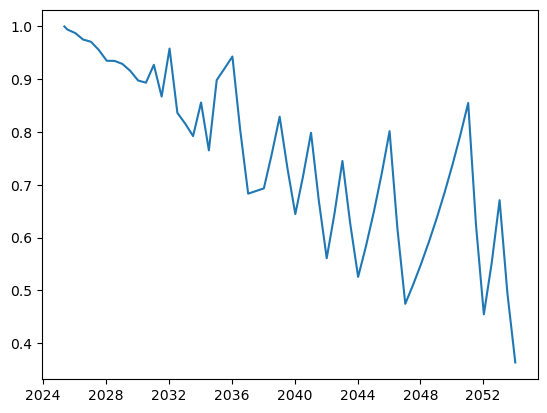

In [613]:
discount_factors_df = pd.DataFrame(index=all_payment_dates)
discount_factors_df.loc[all_payment_dates[0], 'discount_factor'] = 1
figure_date = VALUATION_DATE

for bond_id in bond_dict.keys():
    optim_value = fsolve(func=func_to_solve_interpolation, x0=0.99, args=(discount_factors_df, bond_dict, bond_id, figure_date))
    

discount_factors_df['Date'] = all_payment_dates
discount_factors_df['Time'] = discount_factors_df.apply(lambda row: tau(start_date=VALUATION_DATE, end_date=row['Date'], day_count_convention='ACT/ACT'), axis=1) 
discount_factors_df = interpolate_strict(df=discount_factors_df, x_col='Time', y_col='discount_factor')

plt.plot(discount_factors_df['Date'], discount_factors_df['discount_factor']) 

In [615]:
discount_factors_df

,discount_factor,Date,Time,nan_group
0,1.000000,2025-05-07,0.000000,1
1,0.994254,2025-07-15,0.189041,1
2,0.987495,2026-01-15,0.693151,1
3,0.975267,2026-07-15,1.189041,1
4,0.971025,2027-01-15,1.693151,1
5,0.955587,2027-07-15,2.189041,1
6,0.934968,2028-01-17,2.698510,1
7,0.934746,2028-07-17,3.195778,1
8,0.928975,2029-01-15,3.693151,1
9,0.915796,2029-07-16,4.191781,1


# PROBLEM

The discount_factors_df dataframe is changed with interpolated values, after guessing the first time a discount_factor for the maturity date. After, while we optimize, the discount_factors_df is already filled with values instead of NaN. So the system doesn't interpolate. This gives these weird patterns.

Below is a ChatGPT solution [still have to look at it]:

- Idea is to use a copy of the dataframe, to not mess with the structure. 
- Still have to look at whether the interpolated values are assigned to the discount_factors_df after optimization, How?

In [643]:
def func_to_solve_interpolation(discount_factor_guess, discount_factors_df_orig, bond_dict, bond_id, figure_date):
    # Work on a copy to avoid contaminating global state
    discount_factors_df = discount_factors_df_orig.copy()
    
    bond = bond_dict[bond_id]
    bond_payment_dates = bond.get_payment_dates(figure_date=figure_date)
    bond_cashflow_df = bond.get_cashflow_df(figure_date=figure_date)
    price = bond.get_price()
    maturity_date = bond.get_maturity_date()
    maturity_business_day = next_business_day(figure_date=maturity_date, business_days=target_days)

    t = float(bond_cashflow_df[bond_cashflow_df['payment_date'] == maturity_business_day]['time_to_figure_date'].values[0])
    
    # Apply guessed discount factor only to the maturity date
    discount_factors_df.loc[maturity_business_day, 'discount_factor'] = discount_factor_guess[0]
    
    # Reset any other payment dates (except known dates like the first) to NaN to force interpolation
    for date in bond_payment_dates:
        print(pd.isna(discount_factors_df.loc[date, 'discount_factor']))
        if date != maturity_business_day and pd.isna(discount_factors_df.loc[date, 'discount_factor']):
            
            discount_factors_df.loc[date, 'discount_factor'] = np.nan

    # Pull discount factors into bond cashflow df
    bond_cashflow_df['discount_factor'] = bond_cashflow_df.apply(
        lambda row: discount_factors_df.loc[row['payment_date'], 'discount_factor'], axis=1
    )

    if not bond_cashflow_df['discount_factor'].isna().any():
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()
    else:
        print(f"For bond {bond.get_description()}, we must interpolate.")
        df_interp = interpolate_strict(df=bond_cashflow_df, x_col='time_to_figure_date', y_col='discount_factor')
        bond_cashflow_df['discount_factor'] = df_interp['discount_factor']
        npv = (bond_cashflow_df['cashflow'] * bond_cashflow_df['discount_factor']).sum()

    return( npv - price )


In [644]:
discount_factors_df = pd.DataFrame(index=all_payment_dates)
discount_factors_df['discount_factor'] = np.nan
discount_factors_df.loc[all_payment_dates[0], 'discount_factor'] = 1  # Initial anchor
figure_date = VALUATION_DATE

selected_bonds = list(bond_dict.keys())
# selected_bonds = selected_bonds[7:25]

for bond_id in selected_bonds:
    result = fsolve(func=func_to_solve_interpolation, x0=[0.99], args=(discount_factors_df, bond_dict, bond_id, figure_date))
    
    # Set optimized discount factor in main DF
    bond = bond_dict[bond_id]
    maturity_date = bond.get_maturity_date()
    maturity_business_day = next_business_day(figure_date=maturity_date, business_days=target_days)
    discount_factors_df.loc[maturity_business_day, 'discount_factor'] = result[0]


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

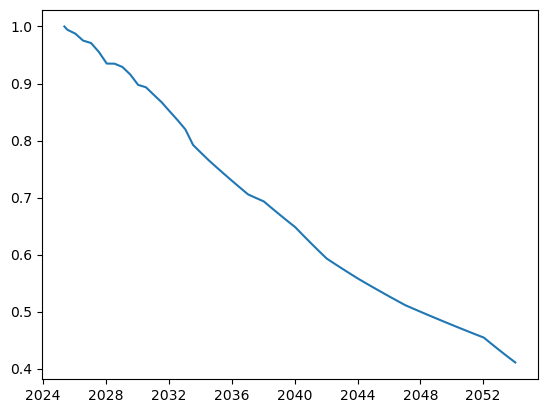

In [640]:
discount_factors_df['Date'] = discount_factors_df.index
discount_factors_df['Time'] = discount_factors_df['Date'].apply(
    lambda d: tau(start_date=VALUATION_DATE, end_date=d, day_count_convention='ACT/ACT')
)

discount_factors_df = interpolate_strict(df=discount_factors_df, x_col='Time', y_col='discount_factor')

plt.plot(discount_factors_df['Date'], discount_factors_df['discount_factor'])


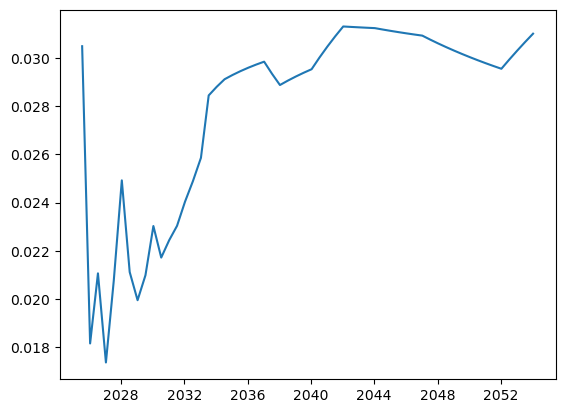

In [641]:
discount_factors_df['zero_rate'] = - np.log(discount_factors_df['discount_factor']) / discount_factors_df['Time']
plt.plot(discount_factors_df['Date'], discount_factors_df['zero_rate'])


In [642]:
discount_factors_df

,discount_factor,Date,Time,nan_group,zero_rate
0,1.000000,2025-05-07,0.000000,1,NaN
1,0.994254,2025-07-15,0.189041,1,0.030481
2,0.987495,2026-01-15,0.693151,1,0.018155
3,0.975267,2026-07-15,1.189041,1,0.021062
4,0.971025,2027-01-15,1.693151,1,0.017366
5,0.955587,2027-07-15,2.189041,1,0.020753
6,0.934968,2028-01-17,2.698510,1,0.024918
7,0.934746,2028-07-17,3.195778,1,0.021115
8,0.928975,2029-01-15,3.693151,1,0.019949
9,0.915796,2029-07-16,4.191781,1,0.020984


In [632]:
for bond_id in bond_dict.keys():
    sys_yield = (bond_dict[bond_id].get_yield(figure_date=dt(year=2025, month=4, day=20))*100)
    df_yield = (dsl_df.loc[(bond_id), 'Mid'])
    print(f"{bond_id}. Bond: {bond_dict[bond_id].get_description()}")
    # print('-----------------------------------------------------------')
    # print(f"Yield according to system: {sys_yield:.3f}")
    # print(f"Yield according to df:     {df_yield:.3f}")
    # print(f"Difference:                {((sys_yield - df_yield)*100):.3f}bp")
    # print('-----------------------------------------------------------\n')

1. Bond: NETHER 0 1/4 07/15/25
2. Bond: NETHER 0 01/15/26
3. Bond: NETHER 0 1/2 07/15/26
4. Bond: NETHER 0 01/15/27
5. Bond: NETHER 0 3/4 07/15/27
6. Bond: NETHER 5 1/2 01/15/28
7. Bond: NETHER 0 3/4 07/15/28
8. Bond: NETHER 0 01/15/29
9. Bond: NETHER 0 1/4 07/15/29
10. Bond: NETHER 2 1/2 01/15/30
11. Bond: NETHER 0 07/15/30
12. Bond: NETHER 0 07/15/31
13. Bond: NETHER 0 1/2 07/15/32
14. Bond: NETHER 2 1/2 01/15/33
15. Bond: NETHER 2 1/2 07/15/33
16. Bond: NETHER 2 1/2 07/15/34
17. Bond: NETHER 4 01/15/37
18. Bond: NETHER 0 01/15/38
19. Bond: NETHER 0 1/2 01/15/40
20. Bond: NETHER 3 3/4 01/15/42
21. Bond: NETHER 3 1/4 01/15/44
22. Bond: NETHER 2 3/4 01/15/47
23. Bond: NETHER 0 01/15/52
24. Bond: NETHER 2 01/15/54
